In [32]:
# imports
import pandas as pd
import folium
import os
import requests
import matplotlib.pyplot as plt

In [17]:
# import vacation data
vacation = pd.read_csv('./data/vacation_geo.csv')
vacation['Name'] = vacation[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(vacation.columns)
print(vacation.shape)
vacation.head()

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(47, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Highland,Denver,Colorado,USA,39.761133,-105.026392,"Highland, Denver, Colorado, USA"
1,Lodo,Denver,Colorado,USA,39.758270,-104.997257,"Lodo, Denver, Colorado, USA"
2,River North,Denver,Colorado,USA,39.768557,-104.980489,"River North, Denver, Colorado, USA"
3,Manitou Springs,Manitou Springs,Colorado,USA,38.854896,-104.898813,"Manitou Springs, Manitou Springs, Colorado, USA"
4,Downtown,Atlanta,Georgia,USA,33.759502,-84.387993,"Downtown, Atlanta, Georgia, USA"


In [18]:
# check locations
vacation[['Region','Country']].value_counts()

Region          Country
Ontario         Canada     11
Quebec          Canada      5
Georgia         USA         5
Tokyo           Japan       4
Florida         USA         4
Colorado        USA         4
California      USA         3
Tennessee       USA         2
South Carolina  USA         2
Kyoto           Japan       2
Yamanashi       Japan       1
Osaka           Japan       1
Nara            Japan       1
Louisiana       USA         1
Alabama         USA         1
dtype: int64

In [21]:
# visualize postal codes where borough contains "Toronto"
latitude = vacation.lat.mean()
longitude = (vacation.lon.max() + vacation.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, name in zip(vacation['lat'], 
                          vacation['lon'],
                          vacation['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [15]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
vacation_venues = getNearbyVenues(names=vacation['Name'],
                                 latitudes=vacation['lat'],
                                 longitudes=vacation['lon']
                                )
print("All done!")

All done!


In [27]:
print(vacation_venues.shape)
vacation_venues.head()

(2780, 7)


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Highland Park,39.762880,-105.026054,Park
1,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Tacos Tequila Whiskey,39.762012,-105.030019,Taco Place
2,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Orangetheory Fitness,39.762002,-105.030061,Gym
3,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Starbucks,39.760393,-105.024941,Coffee Shop
4,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Denver Bread Company,39.762274,-105.030000,Bakery


In [29]:
print('There are {} uniques categories.'.format(len(vacation_venues['Venue Category'].unique())))

There are 319 uniques categories.


Lots of coffee shops!
count            2780
unique            319
top       Coffee Shop
freq              138
Name: Venue Category, dtype: object
Coffee Shop            0.049640
Café                   0.045683
Hotel                  0.042446
Japanese Restaurant    0.026978
Bar                    0.025540
Pizza Place            0.019065
Italian Restaurant     0.019065
Restaurant             0.016547
American Restaurant    0.014029
Bakery                 0.013669
Name: Venue Category, dtype: float64


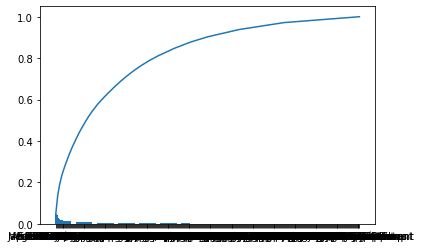

In [34]:
print("Lots of coffee shops!")
print(vacation_venues['Venue Category'].describe())
t = vacation_venues['Venue Category'].value_counts(normalize=True)
print(t.head(10))
x = t.index.values
h = t.values
c = h.cumsum()
plt.bar(x, h)
plt.plot(x, c)